In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
df=pd.read_csv('sal.csv')
df = df[df['District']=='Tweed']
a = df[df['Method']=='Fixed Engine: Retained']
a = a.drop([	'District',	'District ID',	'Report order','Region','Method',	'Wild MSW number','Sea trout number','Sea trout weight (kg)','Finnock number','Finnock weight (kg)','Farmed MSW number','Farmed MSW weight (kg)','Farmed 1SW number','Farmed 1SW weight (kg)','Netting effort',"Wild 1SW number"	,"Wild 1SW weight (kg)","Month"], axis=1)
a.insert(2,'Day','01')
a['Month number'] = a['Month number'].astype(int).apply(lambda x: f"{x:02}")
a['Day'] = a['Day'].astype(int).apply(lambda x: f"{x:02}")

In [3]:
a['Year'] = pd.to_numeric(a['Year'], errors='coerce')
a['Year'] = a['Year'].astype('Int64')
a['Year'] = a['Year'].astype(str)
a['ds'] = pd.DatetimeIndex(a['Year']+'-'+a['Month number']+'-'+a['Day'])

In [4]:
a

,Year,Month number,Day,Wild MSW weight (kg),ds
0,1952,02,01,400.5,1952-02-01
2,1952,03,01,703.1,1952-03-01
4,1952,04,01,1912.3,1952-04-01
6,1952,05,01,3310.3,1952-05-01
8,1952,06,01,2190.9,1952-06-01
...,...,...,...,...,...
905,2017,05,01,0.0,2017-05-01
907,2017,06,01,0.0,2017-06-01
909,2017,07,01,0.0,2017-07-01
911,2017,08,01,0.0,2017-08-01


In [5]:
a=a.drop(['Year',	'Month number',	'Day'],axis=1)
a

,Wild MSW weight (kg),ds
0,400.5,1952-02-01
2,703.1,1952-03-01
4,1912.3,1952-04-01
6,3310.3,1952-05-01
8,2190.9,1952-06-01
...,...,...
905,0.0,2017-05-01
907,0.0,2017-06-01
909,0.0,2017-07-01
911,0.0,2017-08-01


In [6]:
a = a.drop(a.tail(15).index)


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
a['Wild MSW weight (kg)'] = scaler.fit_transform(a['Wild MSW weight (kg)'].values.reshape(-1, 1))
a
# Create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_sequences(a[['Wild MSW weight (kg)']].values, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Build the LSTM model with different hyperparameters
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(time_step, 1)))  # Adjusted units
model.add(Dropout(0.4))  # Adjusted Dropout
model.add(LSTM(75, return_sequences=False))  # Adjusted units
model.add(Dropout(0.4))  # Adjusted Dropout
model.add(Dense(30))  # Adjusted units
model.add(Dense(1))


# Compile the model with improved optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
checkpoint_path = '/Desktop/time forcaste (1)/best_model_weights.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    batch_size=1, 
                    epochs=100, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
268/268 [==============================] - 20s 34ms/step - loss: 0.0273 - val_loss: 0.0189
Epoch 2/100
268/268 [==============================] - 6s 23ms/step - loss: 0.0258 - val_loss: 0.0214
Epoch 3/100
268/268 [==============================] - 6s 23ms/step - loss: 0.0241 - val_loss: 0.0262
Epoch 4/100
268/268 [==============================] - 6s 21ms/step - loss: 0.0251 - val_loss: 0.0204
Epoch 5/100
268/268 [==============================] - 6s 22ms/step - loss: 0.0238 - val_loss: 0.0221
Epoch 6/100
268/268 [==============================] - 6s 22ms/step - loss: 0.0240 - val_loss: 0.0195
Epoch 7/100
268/268 [==============================] - 6s 21ms/step - loss: 0.0216 - val_loss: 0.0168
Epoch 8/100
268/268 [==============================] - 6s 23ms/step - loss: 0.0220 - val_loss: 0.0163
Epoch 9/100
268/268 [==============================] - 6s 22ms/step - loss: 0.0219 - val_loss: 0.0159
Epoch 10/100
268/268 [==============================] - 6s 22ms/step - loss: 0.02

3/3 [==============================] - 3s 15ms/step
Mean Squared Error (MSE): 225151.6294114717
Root Mean Squared Error (RMSE): 474.5014535398935
Mean Absolute Error (MAE): 274.9224662926618
R-squared (R²): 0.5726507756089213
1/1 [==============================] - 0s 79ms/step


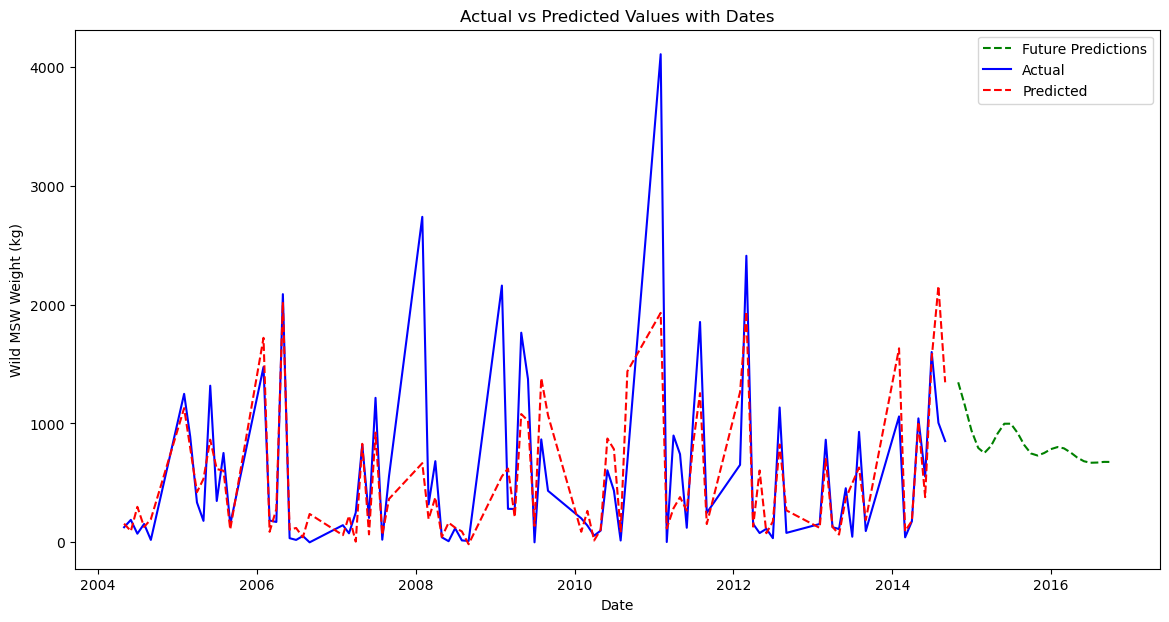

In [19]:
model = tf.keras.models.load_model(checkpoint_path)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler.inverse_transform(y_pred)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Mean Absolute Error (MAE): {mae}')

# R-squared (R²)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
print(f'R-squared (R²): {r2}')
n_future_months = 24  # Number of months to predict into the future (2 years)
future_predictions = []
last_sequence = X_test[-1]  # Start with the last sequence in the test set

for _ in range(n_future_months):
    next_pred = model.predict(last_sequence.reshape(1, time_step, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(time_step, 1)

# Inverse transform the future predictions to the original scale
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates for the next 24 months
last_date = a['ds'].max()
future_dates = pd.date_range(start=last_date, periods=n_future_months + 1, freq='ME', inclusive='right')[1:]

# Create a DataFrame with future dates and predicted values
future_df = pd.DataFrame({'ds': future_dates, 'Predicted Weight (kg)': future_predictions_unscaled.flatten()})

# Inverse transform the actual values to the original scale
actual_values_unscaled = scaler.inverse_transform(a['Wild MSW weight (kg)'].values.reshape(-1, 1))

# Plot the actual and predicted values along with future predictions
plt.figure(figsize=(14, 7))

plt.plot(future_df['ds'], future_df['Predicted Weight (kg)'], color='green', linestyle='--', label='Future Predictions')

# Plot the actual vs predicted values with dates
plt.plot(a['ds'][-len(y_test_unscaled):], y_test_unscaled, color='blue', label='Actual')
plt.plot(a['ds'][-len(y_pred_unscaled):], y_pred_unscaled, color='red', linestyle='--', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Wild MSW Weight (kg)')
plt.title('Actual vs Predicted Values with Dates')
plt.legend()
plt.show()

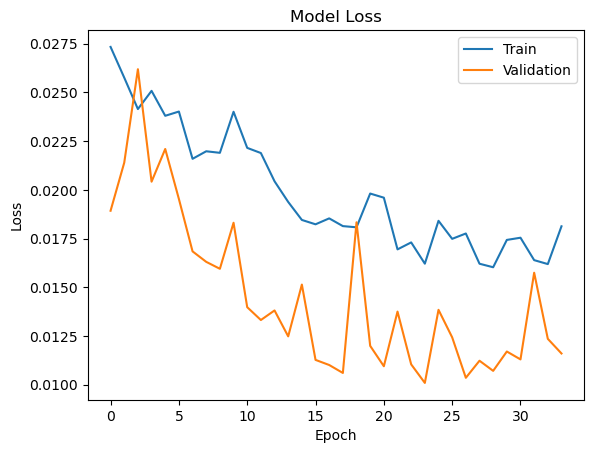

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 79ms/step


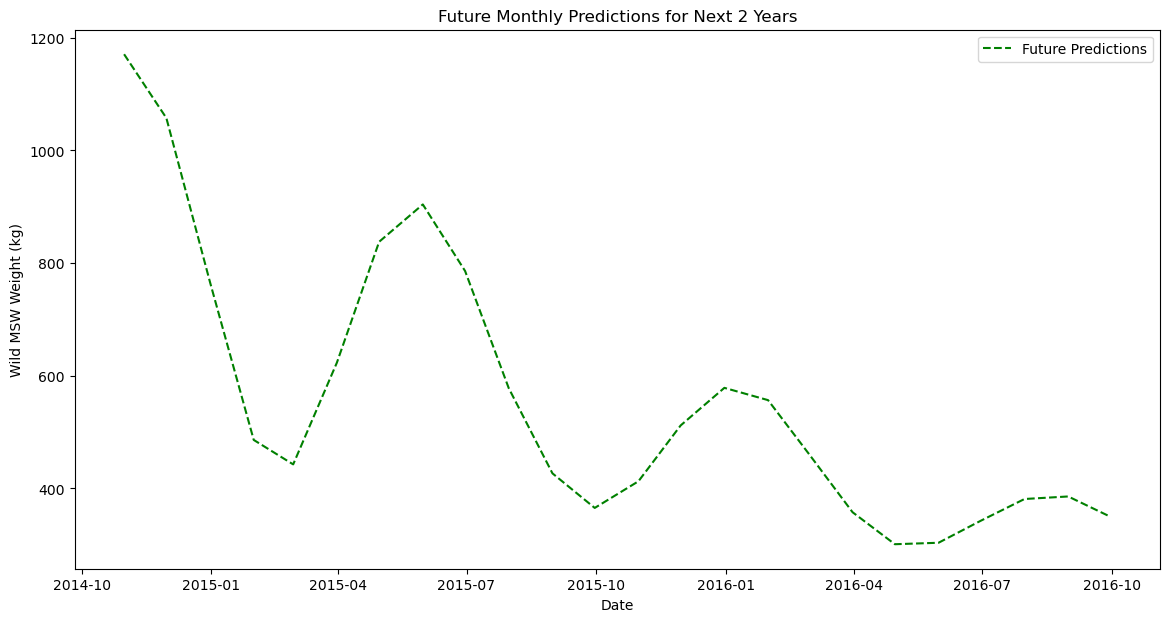

In [29]:
n_future_months = 24  # Number of months to predict into the future (2 years)
future_predictions = []
last_sequence = X_test[-1]  # Start with the last sequence in the test set

for _ in range(n_future_months):
    next_pred = model.predict(last_sequence.reshape(1, time_step, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(time_step, 1)

# Inverse transform the future predictions to the original scale
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates for the next 24 months
last_date = a['ds'].max()
future_dates = pd.date_range(start=last_date, periods=n_future_months + 1, freq='ME', inclusive='right')[1:]

# Create a DataFrame with future dates and predicted values
future_df = pd.DataFrame({'ds': future_dates, 'Predicted Weight (kg)': future_predictions_unscaled.flatten()})

# Plot only the future predictions
plt.figure(figsize=(14, 7))
plt.plot(future_df['ds'], future_df['Predicted Weight (kg)'], color='green', linestyle='--', label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Wild MSW Weight (kg)')
plt.title('Future Monthly Predictions for Next 2 Years')
plt.legend()
plt.show()

In [65]:

import json
actual_data = []
predicted_data = []
future_predicted_data = []
for date, actual_value, predicted_value in zip(a['ds'], actual_values_unscaled.flatten(), y_pred_unscaled.flatten()):
    actual_data.append({
        'Date': str(date),
        'Actual': float(actual_value),
        'Predicted': float(predicted_value)
    })
for date, future_value in zip(future_df['ds'], future_predictions_unscaled.flatten()):
    future_predicted_data.append({
        'Date': str(date),
        'Future_Predicted': float(future_value)
    })

# Combine all data into a single dictionary
combined_data = {
    'Actual_and_Predicted': actual_data,
    'Future_Predictions': future_predicted_data
}

# Save the data to a JSON file
with open('prediction_1.json', 'w') as json_file:
    json.dump(combined_data, json_file, indent=4)

print("Predictions saved to predictions_1.json")

Predictions saved to predictions_1.json


In [31]:
# Save the entire model as a .h5 file
model.save('lstm_model.h5')

print("Model saved as .h5 file.")


Model saved as .h5 file.


In [33]:
import pickle

# Save the model architecture as JSON
model_json = model.to_json()

# Save the model architecture to a JSON file
with open("lstm_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to a separate H5 file
model.save_weights("lstm_model_weights.h5")

print("Model architecture saved as JSON and weights saved as H5.")


Model architecture saved as JSON and weights saved as H5.


In [35]:
# Create a dictionary to store paths to model architecture and weights
model_data = {
    'architecture_path': "lstm_model_architecture.json",
    'weights_path': "lstm_model_weights.h5"
}

# Save the dictionary as a pickle file
with open('lstm_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)

print("Model paths saved in a pickle file.")


Model paths saved in a pickle file.
